# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [11]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


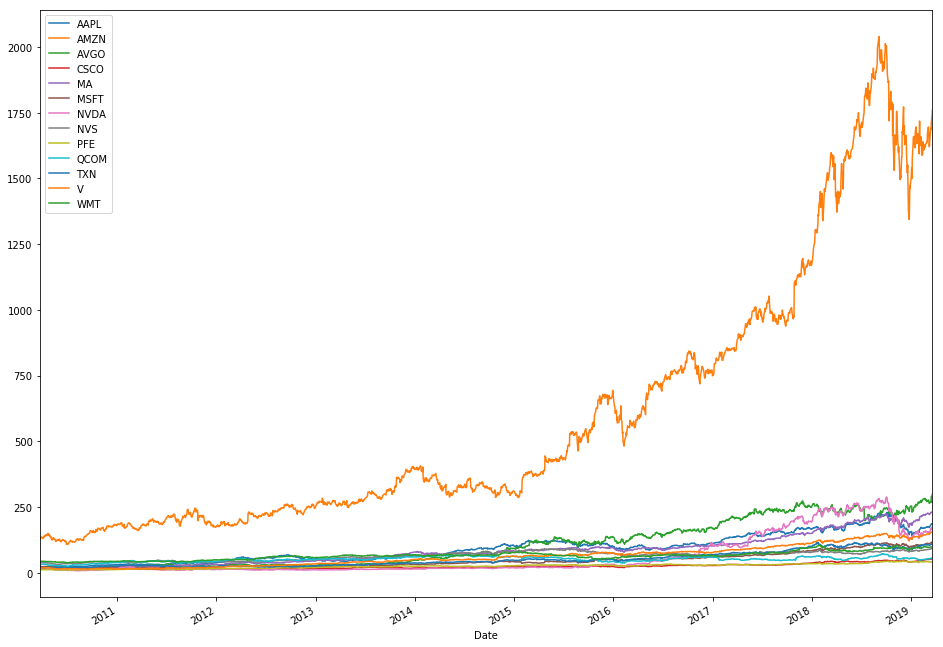

In [12]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [13]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [14]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


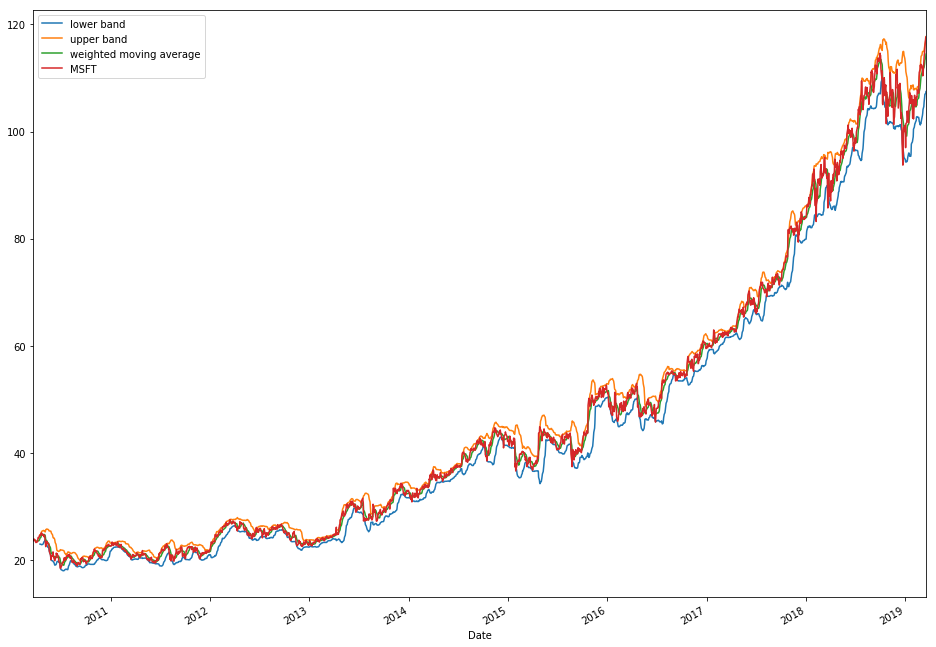

In [15]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization

In [23]:
from sklearn import preprocessing

normalized_stock_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    scaled_df.head()
    normalized_stock_list.append(scaled_df)
    
    
print(normalized_stock_list)






[          High       Low      Open     Close    Volume  Adj Close      MACD  \
0     0.000000  0.014831  0.000000  0.000000  0.223703   0.000000       NaN   
1     0.001974  0.017634  0.003706  0.002579  0.303269   0.001646       NaN   
2     0.002982  0.020054  0.005140  0.003301  0.300735   0.002107       NaN   
3     0.003529  0.019160  0.007491  0.001357  0.270493   0.000867       NaN   
4     0.004225  0.020792  0.006079  0.004394  0.324219   0.002805       NaN   
5     0.005588  0.022970  0.008982  0.005458  0.269654   0.003484       NaN   
6     0.008152  0.024837  0.011563  0.007930  0.262333   0.005062       NaN   
7     0.007534  0.024986  0.010767  0.007323  0.209666   0.004675       NaN   
8     0.009039  0.023772  0.012143  0.008016  0.303658   0.005117       NaN   
9     0.008883  0.025206  0.010402  0.009816  0.347995   0.006266       NaN   
10    0.010112  0.026788  0.012710  0.010566  0.218579   0.006745       NaN   
11    0.011305  0.027966  0.013678  0.011324  0.317

/home/omer/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: Solution Model


Index(['High', 'Low', 'Open', 'Close', 'Adj Close'], dtype='object')


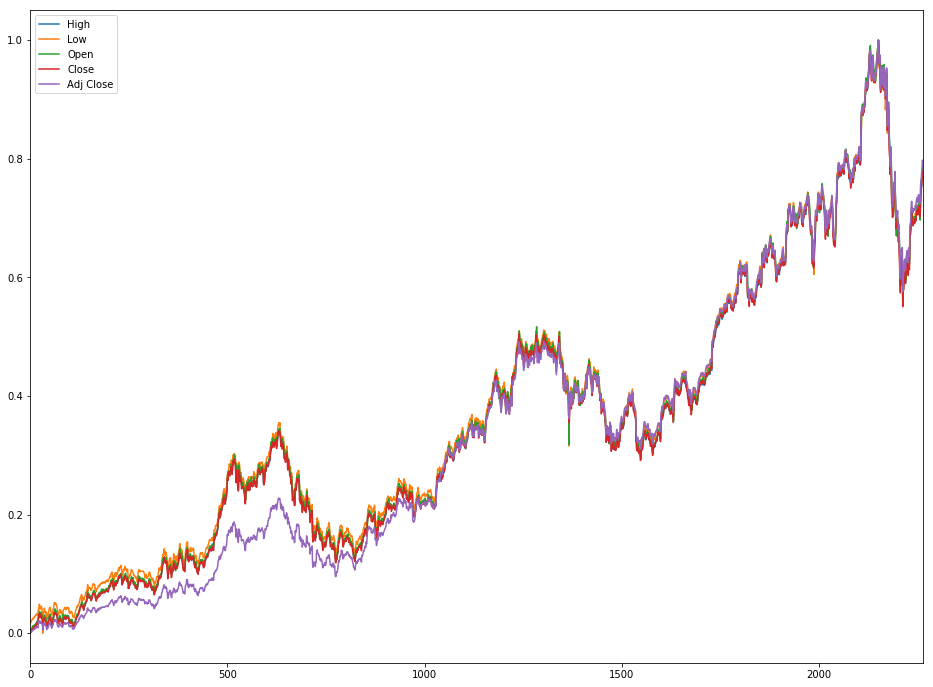

In [9]:
# A- For Benchmark we will use standart linear regression






In [99]:
print(scaled_df)

          High       Low      Open     Close  Adj Close
0     0.480611  0.468170  0.468851  0.477953   0.318700
1     0.478279  0.468495  0.471715  0.477401   0.318332
2     0.477335  0.471757  0.472027  0.475614   0.317141
3     0.479452  0.469654  0.479348  0.470484   0.313720
4     0.477995  0.470988  0.471812  0.475831   0.317285
5     0.476741  0.472154  0.474967  0.473724   0.315880
6     0.477250  0.470758  0.475481  0.473974   0.316047
7     0.476867  0.472534  0.474610  0.473622   0.315813
8     0.479413  0.467404  0.476762  0.473870   0.315978
9     0.477607  0.470117  0.470538  0.477567   0.318443
10    0.477137  0.470702  0.473086  0.475747   0.317230
11    0.477675  0.471238  0.472995  0.475068   0.316777
12    0.477393  0.470475  0.475219  0.474250   0.316232
13    0.475230  0.472421  0.474326  0.475034   0.316754
14    0.475765  0.473299  0.474063  0.474239   0.316224
15    0.475725  0.472414  0.473884  0.475000   0.316732
16    0.475393  0.472028  0.474368  0.475161   0

In [15]:
from sklearn.preprocessing import MinMaxScaler
X = [[4, 1, 2, 2],
     [1, 3, 9, 3],
     [5, 7, 5, 1]]
transformer = MinMaxScaler().fit(X) # fit does nothing.
transformer

transformer.transform(X)

array([[0.75      , 0.        , 0.        , 0.5       ],
       [0.        , 0.33333333, 1.        , 1.        ],
       [1.        , 1.        , 0.42857143, 0.        ]])